# Deep Learning with MXNet in Google Colab

Frameworks for building deep learning models:  PyTorch, Tensorflow, Theano, MxNet. 

For Big Data, use MxNet (with multi-GPU support built in), MxNet provides the easiest abstractions to do this and works well with AWS as well as Colab. 




### Deep Learning Applications:


Deep learning has been significantly improved voice command systems (such as Siri and Alexa), as well as healthcare and image identification.

Deep learning has applications across numerous industries, such as Google’s very human-like talking AI, a new theory that cracks the 'black box' of deep learning, and various budding ideas like this one about why human forgetting might be the key to AI. Here are some cool applications of deep learning - 


## MxNet Installation

In [ ]:
!nvidia-smi

Wed Jan 12 11:16:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    75W / 149W |   2305MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%capture
!pip3 install --upgrade mxnet-cu101 gluoncv


In [ ]:
import mxnet as mx
from gluoncv.utils import viz
from mxnet.gluon.data import DataLoader
from mxnet.gluon.data.vision import transforms
from mxnet import np

import shutil
# shutil module offers high-level operations on files and collections of files. 

In [ ]:
from mxnet import np, npx
from mxnet.gluon import nn
npx.set_np()

if npx.num_gpus() < 1:
  raise "No GPU is found, please restart your runtime!"

# Indoor Scene Recognition with MXNet

Indoor scene recognition is a challenging open problem. Most scene recognition models that work well for outdoor scenes perform poorly in the indoor domain. The main difficulty is that while some indoor scenes (e.g. corridors) can be well characterized by global spatial properties, others (e.g., bookstores) are better characterized by the objects they contain. More generally, to address the indoor scenes recognition problem we need a model that can exploit local and global discriminative information.

  - The dataset contains 67 Indoor categories. The number of images varies across categories, but there are at least 100 images per category. All images are in jpg format.

Download the dataset

In [ ]:
!wget -nc https://storage.googleapis.com/penn-cis545/data.zip
!unzip -nq "data.zip"

File ‘data.zip’ already there; not retrieving.



## Filter out corrupt and nonexistent images 





In [ ]:
import os
from PIL import Image

base_path = 'indoorCVPR_09/Images' # / each name of categories 
train_path = os.path.join(base_path, 'train/')
test_path = os.path.join(base_path,'test/')
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)


def check_corrupt(filename):
  
    try:
      img=Image.open(filename)
      if img.mode == 'P': # RGB image mode
        return True
    
    except IOError:
      return False

# Check all images in the train file for validity and write the valid ones to train_path
with open("TrainImages.txt", "r") as train_file:
  correct_file_count_train = 0
  for file in train_file:
      image_path = os.path.join(base_path,file.rstrip('\n'))
      dest_folder = os.path.join(train_path, file.split('/')[0])
      os.makedirs(dest_folder, exist_ok=True)
      dest_path = os.path.join(train_path,file.rstrip('\n'))
      if os.path.getsize(image_path) == 0 or check_corrupt(image_path):
          continue
      correct_file_count_train += 1
      dest = shutil.move(image_path, dest_path)  

correct_file_count_test = 0
with open("TestImages.txt", "r") as test_file:
  for file in test_file:
      image_path = os.path.join(base_path,file.rstrip('\n'))
      dest_folder = os.path.join(test_path, file.split('/')[0])
      os.makedirs(dest_folder, exist_ok=True)
      dest_path = os.path.join(test_path,file.rstrip('\n'))
      if os.path.getsize(image_path) == 0 or check_corrupt(image_path):
          continue
      correct_file_count_test += 1
      dest = shutil.move(image_path, dest_path)  

In [ ]:
train_path, test_path

('indoorCVPR_09/Images/train/', 'indoorCVPR_09/Images/test/')

## Build a dataset class 

- Create train and test datasets for loading image files stored in a folder structure within train_path and test_path. (using signature: mx.gluon.data.vision.datasets.ImageFolderDataset(*args, **kwargs) ) 

- the image pixels  are `float`s in the range `[0,1]` and not `int`egers between `[0,255]` (transform parameter)

- datasets : `train_dataset` and `test_dataset`.

- Reference [here](https://mxnet.apache.org/versions/1.7.0/api/python/docs/tutorials/packages/gluon/data/datasets.html#Machine-learning-with-Datasets-and-DataLoaders).


In [ ]:
# Create train_dataset and test_dataset


def transform(data, label):
    data = data.astype('float32')/255
    return data, label

# Bring all files transformed into dataset 
train_dataset = mx.gluon.data.vision.datasets.ImageFolderDataset(train_path, transform=transform)
test_dataset = mx.gluon.data.vision.datasets.ImageFolderDataset(test_path, transform=transform)





## Visualize images from the dataset

 : training and testing datasets (binary form) to plotting data points 


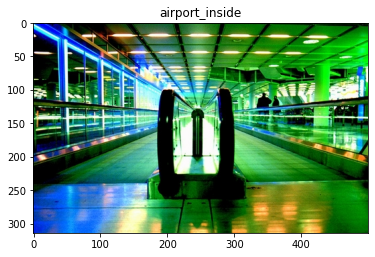

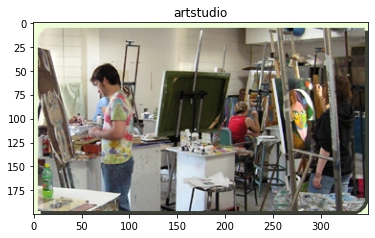

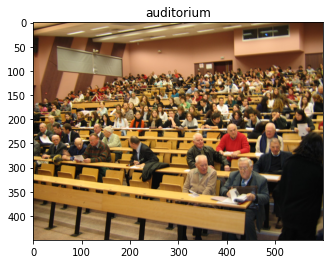

In [ ]:
# Visualize 10 images in the dataset : data, label 

%matplotlib inline

import matplotlib.pyplot as plt

sample_idxs = [5, 89, 215]
for sample_idx in sample_idxs:
    data, label = train_dataset[sample_idx]
    plt.imshow(data.asnumpy())
    plt.title(train_dataset.synsets[label])
    plt.show()


- Images are all different sizes and can be hard to classify 

## Class frequency distributions [optional]

- Create a frequency distribution of the classes in the training dataset. We're going to do this with a *dataset loader* which iterates through the dataset items in batches. (We need to do this or else we'll run out of RAM trying to load everything!)

Within `create_frequency_dict` you should iterate over the batches (already done) and then the items in a batch.

You should create a dictionary with the number of faces belonging to each of the emotions. The key for the dictionary should be the name of the scene and the value should be the frequency in the train dataset.

In [ ]:
def create_frequency_dict(train_dataset_loader, label_names):
    scene_frequency_dict = {}

    for batch_num, (_, label_batch) in enumerate(train_dataset_loader):
      
      # Iterate over the batches, create the scene frequency distribution
      
      label = train_dataset[batch_num][1]
      if label_names[label] not in scene_frequency_dict.keys():
        scene_frequency_dict[label_names[label]] = 1

      else: 
        scene_frequency_dict[label_names[label]] += 1  

    return scene_frequency_dict


train_dataset_loader = mx.gluon.data.DataLoader(train_dataset, 1, shuffle=False, num_workers=1)    
scene_frequency_dict = create_frequency_dict(train_dataset_loader, train_dataset.synsets)
print(scene_frequency_dict)


{'airport_inside': 80, 'artstudio': 80, 'auditorium': 82, 'bakery': 81, 'bar': 82, 'bathroom': 82, 'bedroom': 79, 'bookstore': 80, 'bowling': 80, 'buffet': 79, 'casino': 81, 'children_room': 82, 'church_inside': 81, 'classroom': 82, 'cloister': 80, 'closet': 81, 'clothingstore': 82, 'computerroom': 80, 'concert_hall': 80, 'corridor': 79, 'deli': 81, 'dentaloffice': 79, 'dining_room': 82, 'elevator': 79, 'fastfood_restaurant': 80, 'florist': 81, 'gameroom': 80, 'garage': 81, 'greenhouse': 80, 'grocerystore': 79, 'gym': 82, 'hairsalon': 79, 'hospitalroom': 80, 'inside_bus': 77, 'inside_subway': 79, 'jewelleryshop': 78, 'kindergarden': 80, 'kitchen': 79, 'laboratorywet': 78, 'laundromat': 78, 'library': 79, 'livingroom': 80, 'lobby': 80, 'locker_room': 79, 'mall': 80, 'meeting_room': 78, 'movietheater': 80, 'museum': 77, 'nursery': 80, 'office': 79, 'operating_room': 81, 'pantry': 80, 'poolinside': 79, 'prisoncell': 80, 'restaurant': 80, 'restaurant_kitchen': 77, 'shoeshop': 81, 'stairsca

In [ ]:
len(scene_frequency_dict.keys())

67

the class distribution look uniform!! ( ~ 80) 

## Create Dataloader objects 


- Data loaders to create data batches and to perform transformations on the images. 
- 'transform' function to resize the image to 224 x 224, to center and to convert the image to a *tensor*.

[Refer to](https://mxnet.apache.org/api/python/docs/api/gluon/data/vision/transforms/index.html#mxnet.gluon.data.vision.transforms.Compose) to the transformation documentation


In [ ]:
from mxnet.gluon.data import DataLoader

# Define the transformation and the train and test loaders

transformer = transforms.Compose([transforms.Resize(224),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor()])


train_loader = mx.gluon.data.DataLoader(train_dataset.transform_first(transformer), 32, shuffle=True)
test_loader = mx.gluon.data.DataLoader(test_dataset.transform_first(transformer), 1, shuffle=False)

# Build classifiers
 
 
 

## Logical Logistic Regression - Baseline


- define a logistic regression model in Apache MxNet for multiclass classification
- train and evaluate the performance

*Note*: with mxnet, data (tensors) are typically in `ndarrays`. 
to make numpy arrays, call `as_np_ndarray()` or `as_nd_ndarray()`. 


In [ ]:
# `gluon` and `autograd` modules  to create layers in a neural network.

from mxnet import nd, gluon, autograd, ndarray
from mxnet.gluon import nn

def construct_net():
    num_outputs = 67      # no outputs = num of classes 
    net = nn.Sequential() # Initialize a gluon sequential model
    
    with net.name_scope():
        #  Add a gluon dense layer to the model
        
        net.add(nn.Dense(512,activation='relu'))  
        net.add(nn.Dense(num_outputs))
        
    return net

net = construct_net()

# Set the context to use the available GPUs, otherwise just use a CPU
ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()

- the net initialize function with Xavier Initialization with the context 
- sets starting model weights, 

In [ ]:
# net.initialize(mx.init.Xavier(), ctx=ctx)

Let's print the model summary

In [ ]:
x = mx.sym.var('data')
sym = net(x.as_np_ndarray())
mx.viz.print_summary(sym)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                                                  0                                           
________________________________________________________________________________________________________________________
sequential2_dense0_fwd(FullyConnected)                                      512         data                            
________________________________________________________________________________________________________________________
sequential2_dense0_relu_fwd(Activation)                                     0           sequential2_dense0_fwd          
________________________________________________________________________________________________________________________
sequential2_dense1_fwd(FullyConn

For multi-class classification problem, use the __*categorical cross-entropy* loss function__. (criterion with SoftmaxCrossEntropyLoss())  

Reference:[here](https://mxnet.apache.org/api/python/docs/api/gluon/loss/index.html).

In [ ]:
# Define a gluon Softmax Cross Entropy object, 'criterion', 
# the softmax indicates that the loss function does a softmax first to get the probabilities and then computes the Cross EntropyLoss
criterion = gluon.loss.SoftmaxCrossEntropyLoss() 

Next, we define a trainer object, which includes an optimizer - use a stochastic gradient descent optimizer to optimize for criterion and update weights. 

We need 3 parameters while defining a gluon optimizer. 

1.   Trainable parameters in the model - net.collect_params() gives you all these parameters
2.   An optimizer - 'sgd' or 'adam'. 
3.   Optimizer params - A dictionary with parameters for your optimizer. We only need to specify the learning rate parameter within this dictionary.

The learning rate is a hyperparameter (start with a small learning rate like 0.001)

Reference: [here](https://mxnet.apache.org/api/python/docs/api/gluon/trainer.html).




In [ ]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .003})                                                               

In [ ]:
net

Sequential(
  (0): Dense(-1 -> 512, Activation(relu))
  (1): Dense(-1 -> 67, linear)
)

### Train Model

- Iterate  through our training data multiple times (epoch) to optimize our weights.

- Steps for the training loop: 

  1. Define an [accuracy metric ](https://mxnet.apache.org/api/python/docs/api/metric/index.html) to measure performance.
  2.   Repeat the following for a number of epochs
  3.   Iterate through the mini batches in the training dataloader
      - Each minibatch object will be a tuple `(data, labels)`
      - Each minibatch has a number of images and a number of labels (batch size number of images and labels in each minibatch). Thus each data object will be of the shape `(BATCH_SIZE, 3, 224, 224)`. The 3 corresponds to the number of channels - RGB and the labels array would be of size `(BATCH_SIZE)`
  4.   to get linear inputs (not multiple channels), flatten the image in the batch (reshape)
  5.   Send the data and label to the GPU ( `as_in_ctx` )
  6.   Compute the model outputs for the flattened data using the net object
  7.   Compute the loss function with criterion 
  8.   Compute the accuracy using the metric object defined above.
  9.  __Backpropogate__ through the computed loss value. (the gradients for each of the model parameters)
  10.  Use a trainer to perform an optimizer step - this updates the weights based on the computed gradients wrt the loss function.
  11.  To see how your accuracy improves and the loss decreases, after each epoch print out the accuracy and the loss for that epoch. 


- plot training accuracies and training loss function vs epochs. 


In [ ]:
%time

from mxnet import gluon, autograd, ndarray
losses =[]
accurcies =[]

def evaluate_accuracy(data_iterator, net):
    acc=mx.metric.Accuracy()
   
    for i, (m_data, label) in enumerate(data_iterator):
        a,b,c,d=m_data.shape
        reshaped_data = m_data.reshape(a,b*c*d)
        data = reshaped_data.as_in_context(ctx)
        label = label.as_in_context(ctx)

        output = net(data)
        predictions = nd.argmax(output.as_nd_ndarray(), axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

# Define a training function which trains the passed network 
# return the final training loss and the final training accuracy
def train_network(net, train_loader, criterion, trainer, metric, epochs = 10):
    
    # training loop
    smoothing_constant = .01
    
    for e in range(epochs):
       
        for i, (m_data, label) in enumerate(train_loader):
            a,b,c,d=m_data.shape
            reshaped_data = m_data.reshape(a,b*c*d) # reshape
            data = reshaped_data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            
            with autograd.record():
                output = net(data)
                loss = criterion(output, label)

            loss.backward()
            trainer.step(data.shape[0])  # data = data.as_in_context(ctx)
            
            ##########################
            #  Keep a moving average of the losses
            ##########################
            curr_loss = nd.mean(loss.as_nd_ndarray()).asscalar()
            moving_loss = (curr_loss if ((i == 0) and (e == 0))
                          else (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss)

      
        final_training_accuracy = evaluate_accuracy(train_loader, net)
        final_training_loss = moving_loss 
        final_test_accuracy = evaluate_accuracy(test_loader, net)

        losses.append(final_training_loss)
        accurcies.append(final_training_accuracy)
        print("Epoch %s. Loss: %s, Train_acc %s , test_acc %s" % (e, final_training_loss, final_training_accuracy,final_test_accuracy))
    return final_training_loss, final_training_accuracy


epochs = 10
metric  = mx.metric.Accuracy() 
lr_training_loss, lr_training_accuracy = train_network(net, train_loader, criterion, trainer, metric, epochs)

print("Logistic Regression - the training loss is ", str(lr_training_loss))
print("Logistic Regression - the training accuracy is ", str(lr_training_accuracy))


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Epoch 0. Loss: 4.199806787098317, Train_acc 0.030659936436717144 , test_acc 0.0239880059970015
Epoch 1. Loss: 4.130122751629025, Train_acc 0.042998691344176485 , test_acc 0.04122938530734633
Epoch 2. Loss: 4.060093988490914, Train_acc 0.05178538044494298 , test_acc 0.04272863568215892
Epoch 3. Loss: 3.9985008476013353, Train_acc 0.06449803701626472 , test_acc 0.05847076461769116
Epoch 4. Loss: 3.938398456826155, Train_acc 0.07216302112544401 , test_acc 0.06221889055472264
Epoch 5. Loss: 3.9126635341251124, Train_acc 0.07833239857917368 , test_acc 0.06746626686656672
Epoch 6. Loss: 3.8625154381642846, Train_acc 0.08356702187324734 , test_acc 0.053973013493253376
Epoch 7. Loss: 3.8448834745677805, Train_acc 0.08973639932697701 , test_acc 0.06746626686656672
Epoch 8. Loss: 3.8065567730392416, Train_acc 0.09441017012525706 , test_acc 0.05847076461769116
Epoch 9. Loss: 3.7744674663232227, Train_acc 0.10207515423443635 , test_ac

In [ ]:
accurcies

[0.030659936436717144,
 0.042998691344176485,
 0.05178538044494298,
 0.06449803701626472,
 0.07216302112544401,
 0.07833239857917368,
 0.08356702187324734,
 0.08973639932697701,
 0.09441017012525706,
 0.10207515423443635]

[Text(0, 0.5, 'LR_Accuracy'), Text(0.5, 0, 'epochs')]

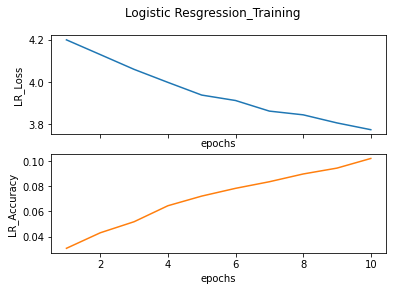

In [ ]:
# Plot training accuracies and training loss function vs epochs!

x = [i for i in range(1,11)]
y1= losses
y2= accurcies

# plot the data
fig = plt.figure()

ax = fig.subplots(2 ,sharex=True)
fig.suptitle('Logistic Resgression_Training')
ax[0].plot(x, y1, color='tab:blue')
ax[1].plot(x, y2, color='tab:orange')

ax[0].set(xlabel='epochs', ylabel='LR_Loss')
ax[1].set(xlabel='epochs', ylabel='LR_Accuracy')


### Evaluate Model

Evaluate the model performance on the test set. Compute the cross entropy loss and accuracy on the test set.

Note:  Please don't report false numbers for the accuracy as we will be reviewing these manually and if if there is a manipulation with the accuracy computation, you will get a 0 for the entire section.


In [ ]:
import time

def test_model(net, criterion, test_loader, metric):
   
    tic = time.time()
    test_loss=0
    # trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.005})

    for i, (m_data, label) in enumerate(test_loader):
        a,b,c,d=m_data.shape
        reshaped_data = m_data.reshape(a,b*c*d) # reshape
        data = reshaped_data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        
        with autograd.record():
            output = net(data)
            loss = criterion(output, label)    
        
 
        test_loss = nd.mean(loss.as_nd_ndarray()).asscalar()  

    final_test_accuracy = evaluate_accuracy(test_loader, net) 
    final_test_loss = test_loss 
    print('test_loss: %.3f | test-acc: %.3f | time: %.1f' %(final_test_loss, final_test_accuracy, time.time() - tic))
    return  final_test_loss, final_test_accuracy
      

metric = mx.metric.Accuracy()  
lr_testing_loss, lr_testing_accuracy = test_model(net, criterion, test_loader, metric)

print("Logistic Regression - the testing loss is ", str(lr_testing_loss))
print("Logistic Regression - the testing accuracy is ", str(lr_testing_accuracy))    
        

test_loss: 4.035 | test-acc: 0.073 | time: 33.2
Logistic Regression - the testing loss is  4.0349584
Logistic Regression - the testing accuracy is  0.0727136431784108


Does the logistic regression fit well to the data? Think about whether this is underfitting or overfitting? Think about if we need more representational power or we need more regularization to make it better?

## Feedforward Neural Networks 

To improve logistic regression, define a feedforward neural network




In [ ]:
from mxnet import gluon, autograd, ndarray, np, npx

def construct_ff_net():
    
    # Create a feedforward network, experiment with the number of hidden layers and
    # the number of sizes of the hidden layers
    num_outputs = 67 # no outputs = num of classes 
    npx.set_np()
    ff_net = nn.Sequential() # Initialize a gluon sequential model
    
    with ff_net.name_scope():
        
        # net.Conv2D(channels=6, kernel_size=5, activation='relu')
        # One can also use a tuple to specify non-symmetric pool and stride sizes
        # net.MaxPool2D(pool_size=2, strides=2)
        # ff_net.add(nn.Flatten())
        ff_net.add(nn.Dense(512,activation='relu'))
        ff_net.add(nn.Dense(512,activation='relu'))
        ff_net.add(nn.Dense(512,activation='relu'))
        
        ff_net.add(nn.Dense(num_outputs))
        
    return ff_net


ff_net  = construct_ff_net()

ff_net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
trainer1 = gluon.Trainer(ff_net.collect_params(), 'adam', {'learning_rate': 0.001})


In [ ]:
x = mx.sym.var('data')
sym = ff_net(x.as_np_ndarray())
mx.viz.print_summary(sym)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                                                  0                                           
________________________________________________________________________________________________________________________
sequential3_dense0_fwd(FullyConnected)                                      512         data                            
________________________________________________________________________________________________________________________
sequential3_dense0_relu_fwd(Activation)                                     0           sequential3_dense0_fwd          
________________________________________________________________________________________________________________________
sequential3_dense1_fwd(FullyConn

Now train this network using the train network function defined above. Create plots for the training accuracy and training loss vs the number of epochs.


In [ ]:
#Train the feedforward neural network on the training set using the train_network function
epochs = 10
metric  = mx.metric.Accuracy() 
ffn_training_loss, ffn_training_accuracy =  train_network(ff_net, train_loader, criterion, trainer1, metric, epochs)


Epoch 0. Loss: 4.205591289199278, Train_acc 0.02056459151243223 , test_acc 0.020989505247376312
Epoch 1. Loss: 4.11129005692085, Train_acc 0.0532809871003926 , test_acc 0.05247376311844078
Epoch 2. Loss: 4.006879258360204, Train_acc 0.06599364367171434 , test_acc 0.05172413793103448
Epoch 3. Loss: 3.930055715162079, Train_acc 0.07627593942793046 , test_acc 0.05622188905547226
Epoch 4. Loss: 3.856016342097054, Train_acc 0.07908020190689849 , test_acc 0.06296851574212893
Epoch 5. Loss: 3.8181368094779744, Train_acc 0.08973639932697701 , test_acc 0.06596701649175413
Epoch 6. Loss: 3.7719022181566, Train_acc 0.09067115348663302 , test_acc 0.06146926536731634
Epoch 7. Loss: 3.7249178225593913, Train_acc 0.10263600673022995 , test_acc 0.07196401799100449
Epoch 8. Loss: 3.692083103730358, Train_acc 0.10843148252009721 , test_acc 0.07496251874062969
Epoch 9. Loss: 3.666209085444199, Train_acc 0.1160964666292765 , test_acc 0.07721139430284858


[Text(0, 0.5, 'ffn_Accuracy'), Text(0.5, 0, 'epochs')]

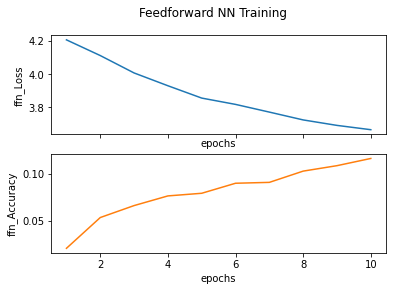

In [ ]:
# gradph for ff_net

x = [i for i in range(1,11)]
y1= losses[10:20]
y2= accurcies[10:20]

# plot the data
fig = plt.figure()

ax = fig.subplots(2 ,sharex=True)
fig.suptitle('Feedforward NN Training')
ax[0].plot(x, y1, color='tab:blue')
ax[1].plot(x, y2, color='tab:orange')

ax[0].set(xlabel='epochs', ylabel='ffn_Loss')
ax[1].set(xlabel='epochs', ylabel='ffn_Accuracy')


In [ ]:
# Compute performance on the test set using the test_network function created before
metric = mx.metric.Accuracy()  
ffn_testing_loss, ffn_testing_accuracy = test_model(ff_net, criterion, test_loader, metric)

print("Logistic Regression - the testing loss is ", str(ffn_testing_loss))
print("Logistic Regression - the testing accuracy is ", str(ffn_testing_accuracy))    
        

test_loss: 2.989 | test-acc: 0.077 | time: 34.8
Logistic Regression - the testing loss is  2.9890182
Logistic Regression - the testing accuracy is  0.07721139430284858


Does the feedforward network do better than logistic regression? Play around with the network architecture to see how it affects the performance on both the train and test data.

## Convoluted Convolutional Neural Networks 

Convolutional Neural Networks are very similar to Feedforward Neural Networks from the previous section: they are made up of neurons that have learnable weights and biases. 
Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. The whole network still expresses a single differentiable score function: from the raw image pixels on one end to class scores at the other.



We will define the architecture for the CNN we will be using. The components of CNNs are: 


*   Convolutional Layers
*   Pooling Layers
*   Linear Layers
*   Activation Functions

Define a CNN model with Mxnet and Gluon with a convolutional layer followed by an activation function and a max pool; then flatten the output from the convolutional layers and pass it through one or more fully connected or 'dense' layers and activation functions after all but the last layer. The output shape from the last layer must be the same as the number of classes.

Reference Here: https://gluon.mxnet.io/chapter03_deep-neural-networks/mlp-gluon.html#Faster-modeling-with-gluon.nn.Sequential

In [ ]:
import mxnet.ndarray as F
from mxnet import gluon, autograd, ndarray, np, npx
from mxnet.gluon import nn


def construct_conv_net():
  
    # Create a cnn network, experiment with the number of hidden layers and
    # the number of sizes of the hidden layers
    
        
    num_outputs = 67  
    # npx.set_np()
    cnn = nn.Sequential()

    with cnn.name_scope():
        
        cnn.add(nn.Conv2D(channels=32, kernel_size=5, activation='relu'))
        cnn.add(nn.MaxPool2D(pool_size=2, strides=2))
        cnn.add(nn.Conv2D(channels=64, kernel_size=3, activation='relu'))
        cnn.add(nn.MaxPool2D(pool_size=2, strides=2))

        cnn.add(nn.Flatten())
        # cnn.add(nn.Dense(128,activation='relu'))
        # cnn.add(nn.Dropout(0.5))
        cnn.add(nn.Dense(512,activation='relu'))
        # cnn.add(nn.Dropout(0.5))
        cnn.add(nn.Dense(512,activation='relu'))
        # cnn.add(nn.Dropout(0.5))
        cnn.add(nn.Dense(num_outputs))
    return cnn   
    


cnn  = construct_conv_net()

cnn.initialize(mx.init.Xavier(), ctx=ctx)
cnn.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

trainer_cnn = gluon.Trainer(cnn.collect_params(), 'adam', {'learning_rate': 0.0001})
criterion = gluon.loss.SoftmaxCrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/mxnet/gluon/parameter.py:896: UserWarning: Parameter 'sequential4_conv0_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.7/dist-packages/mxnet/gluon/parameter.py:896: UserWarning: Parameter 'sequential4_conv1_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.7/dist-packages/mxnet/gluon/parameter.py:896: UserWarning: Parameter 'sequential4_dense0_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.7/dist-packages/mxnet/gluon/parameter.py:896: UserWarning: Parameter 'sequential4_dense1_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit

In [ ]:
#Initialize network, initialize the criterion and the trainer
x = mx.sym.var('data')
sym = cnn(x.as_np_ndarray())
mx.viz.print_summary(sym)



________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                                                  0                                           
________________________________________________________________________________________________________________________
sequential4_conv0_fwd(Convolution)                                          32          data                            
________________________________________________________________________________________________________________________
sequential4_conv0_relu_fwd(Activation)                                      0           sequential4_conv0_fwd           
________________________________________________________________________________________________________________________
sequential4_pool0_fwd(Pooling)  

In [ ]:
from mxnet import gluon, autograd, ndarray

def evaluate_cnn_accuracy(data_iterator, net):
    acc=mx.metric.Accuracy()
   
    for i, (m_data, label) in enumerate(data_iterator):

        data = m_data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output.as_nd_ndarray(), axis=1)
        acc.update(preds=predictions, labels=label)

    return acc.get()[1]

cnn_losses =[]
cnn_accurcies=[]

def train_cnn(net, train_loader, criterion, trainer, metric, epochs = 10):
     
    smoothing_constant = .01
    
    for e in range(epochs):
        cumulative_loss=0
        for i, (data, label) in enumerate(train_loader):
            
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            
            with autograd.record():
                output = net(data)
                loss = criterion(output, label)

            loss.backward()
            trainer.step(data.shape[0]) 
            
            curr_loss = nd.mean(loss.as_nd_ndarray()).asscalar()
            moving_loss = (curr_loss if ((i == 0) and (e == 0))
                       else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)
            
            
            # cumulative_loss += nd.mean(loss.as_nd_ndarray()).asscalar()

        final_test_accuracy = evaluate_cnn_accuracy(test_loader, net)
        final_training_loss = moving_loss 
        final_training_accuracy = evaluate_cnn_accuracy(train_loader, net)
        print('Epoch %s. Loss:%s, Train_acc %s, Test_acc %s' %(e, final_training_loss, final_training_accuracy, final_test_accuracy))     
        
        cnn_losses.append(final_training_loss)
        cnn_accurcies.append(final_training_accuracy)

    return final_training_loss, final_training_accuracy

epochs =20
metric = mx.metric.Accuracy()   
cnn_training_loss, cnn_training_accuracy = train_cnn(cnn, train_loader, criterion, trainer_cnn, metric, epochs)

Epoch 0. Loss:4.2045723273126905, Train_acc 0.01589082071415218, Test_acc 0.015742128935532233
Epoch 1. Loss:4.152902887512396, Train_acc 0.04561600299121331, Test_acc 0.043478260869565216
Epoch 2. Loss:4.03626835658739, Train_acc 0.05458964292391101, Test_acc 0.05847076461769116
Epoch 3. Loss:3.9764288737514013, Train_acc 0.06094597120957188, Test_acc 0.05022488755622189
Epoch 4. Loss:3.9217589953407272, Train_acc 0.07048046363806319, Test_acc 0.05322338830584707
Epoch 5. Loss:3.888299838398682, Train_acc 0.07870630024303608, Test_acc 0.06746626686656672
Epoch 6. Loss:3.850251801362405, Train_acc 0.08767994017573379, Test_acc 0.068215892053973
Epoch 7. Loss:3.801030151805845, Train_acc 0.09777528510001869, Test_acc 0.06671664167916042
Epoch 8. Loss:3.751631099132148, Train_acc 0.11160964666292765, Test_acc 0.06746626686656672
Epoch 9. Loss:3.694634790166193, Train_acc 0.12936997569639186, Test_acc 0.0712143928035982
Epoch 10. Loss:3.6201891277435148, Train_acc 0.13647410730977752, Tes

[Text(0, 0.5, 'cnn_Accuracy'), Text(0.5, 0, 'epochs')]

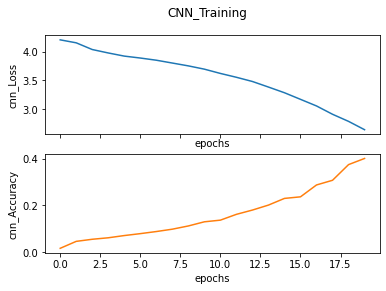

In [ ]:

x = [i for i in range(0,epochs)]
y1= cnn_losses
y2= cnn_accurcies

# plot the data
fig = plt.figure()

ax = fig.subplots(2 ,sharex=True)
fig.suptitle('CNN_Training')
ax[0].plot(x, y1, color='tab:blue')
ax[1].plot(x, y2, color='tab:orange')

ax[0].set(xlabel='epochs', ylabel='cnn_Loss')
ax[1].set(xlabel='epochs', ylabel='cnn_Accuracy')

In [ ]:

import time

def test_cnn_model(net, criterion, test_loader, metric):
    
    tic = time.time()
    test_loss=0
    # trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.005})

    for i, (m_data, label) in enumerate(test_loader):
        
        data = m_data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        
        with autograd.record():
            output = net(data)
            loss = criterion(output, label)    
           
        test_loss = nd.mean(loss.as_nd_ndarray()).asscalar()  

    final_test_accuracy = evaluate_cnn_accuracy(test_loader, net) 
    final_test_loss = test_loss 
    print('test_loss: %.3f | test-acc: %.3f | time: %.1f' %(final_test_loss, final_test_accuracy, time.time() - tic))
    return  final_test_loss, final_test_accuracy
      

metric = mx.metric.Accuracy()  
cnn_testing_loss, cnn_testing_accuracy = test_cnn_model(cnn, criterion, test_loader, metric)

print("Logistic Regression - the testing loss is ", str(cnn_testing_loss))
print("Logistic Regression - the testing accuracy is ", str(cnn_testing_accuracy))  

test_loss: 1.854 | test-acc: 0.080 | time: 41.0
Logistic Regression - the testing loss is  1.8544017
Logistic Regression - the testing accuracy is  0.08020989505247376
